## Inference with Custom Proposals

**This tutorial shows how Gen is used to create custom proposals for inference algorithms.**


Instead of simply guessing proposals from arbitrary functions (i.e. Gaussians), we can 
improve our inference algorithms by adding custom proposals. They are usually written 
with as much prior knowledge about the problem as possible. With better guesses, 
our program has the capability to converge more quickly. 



In [1]:
using Gen
import Distributions
using PyPlot
using StatsBase

# The probabilistic model
function linear_regression(T::Trace, xs::Array{Float64,1})
    prior_mu = 0.0
    prior_std = 2.0
    outlier_noise = 10.0
    prob_outlier = 0.1
    inlier_noise = 0.2
    slope = normal(prior_mu, prior_std) ~ "slope"
    intercept = normal(prior_mu, prior_std) ~ "intercept"
    ys = Array{Float64, 1}(length(xs))
    for i=1:length(xs)
        y_mean = intercept + slope * xs[i]
        noise = (flip(prob_outlier) ~ "o$i") ? outlier_noise : inlier_noise 
        ys[i] = normal(y_mean, noise) ~ "y$i"
    end
end

# A basic RANSAC algorithm 

immutable RansacParams

    # the number of random subsets to try
    iters::Int

    # the number of points to use to construct a hypothesis
    subset_size::Int

    # the error threshold below which a datum is considered an inlier
    eps::Float64
end


function ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end

# A proposal program based on RANSAC
function ransac_proposal(T::Trace, xs::Array{Float64,1},
                         ys::Array{Float64,1},
                         ransac_params::RansacParams, 
                         proposal_std::Float64)

    # use RANSAC to guess the line parameters
    slope, intercept, inliers = ransac_core(xs, ys, ransac_params)

    # add noise to the line parameters
    slope_proposed = normal(slope, proposal_std) ~ "slope"
    intercept_proposed = normal(intercept, proposal_std) ~ "intercept"

    # add some noise to the proposed outlier statuses
    for i=1:length(xs)
        prob_outlier = inliers[i] ? 0.1 : 0.9
        flip(prob_outlier) ~ "o$i"
    end
end

function propose_and_compute_score(xs::Array{Float64,1}, ys::Array{Float64,1},
                                   ransac_params::RansacParams, proposal_std::Float64)

    # run the proposal program
    proposal_trace = Trace()
    proposal_trace.outputs = Set{String}(
        vcat(["slope", "intercept"], ["o$i" for i=1:length(xs)])
    )
    ransac_proposal(proposal_trace, xs, ys, ransac_params, proposal_std)

    # set constraints in the model trace
    model_trace = Trace()
    @in model_trace <= proposal_trace begin
        for (i, y) in enumerate(ys)
            @constrain("y$i", y)
        end
        for name in proposal_trace.outputs
            @constrain(name <= name)
        end
    end
   
    # run the model program to compute the model score
    linear_regression(model_trace, xs)

    # return model trace and score
    score = model_trace.log_weight - proposal_trace.log_weight
    (model_trace, score)
end

function linreg_infer_mh(num_iters::Int, xs::Array{Float64,1}, 
                      ys::Array{Float64,1},proposal_std::Float64)
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 1.)
    

    # initial trace and score
    trace, score = propose_and_compute_score(xs, ys, ransac_params, 
                                             proposal_std)

    # MH iterations
    for iter=1:num_iters
        proposed_trace, proposed_score = propose_and_compute_score(xs, ys, ransac_params, 
                                                                   proposal_std)
        if log(rand()) <= proposed_score - score
            # accept
            score = proposed_score
            trace = proposed_trace
        else
            # reject
            nothing
        end
    end

    # return the final iterate of the Markov chain
    trace
end

function linreg_infer_sir(num_samples::Int, xs::Array{Float64,1}, 
                          ys::Array{Float64,1})
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 1.)
    proposal_std = 0.2

    log_weights = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace, score = propose_and_compute_score(xs, ys, ransac_params, proposal_std)
        traces[sample] = trace
        log_weights[sample] = score
    end
    weights = exp(log_weights - logsumexp(log_weights))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end

function render_linreg_trace(trace::Trace, xs::Array{Float64,1})
    ax = plt[:gca]()
    n = length(xs)
    ys = map((i) -> trace.vals["y$i"], 1:n)
    outlier_statuses = map((i) -> trace.vals["o$i"], 1:n)
    slope = trace.vals["slope"]
    intercept = trace.vals["intercept"]
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    colors = map((i) -> outlier_statuses[i] ? "orange" : "blue", 1:n)
    plt[:scatter](xs, ys, c=colors)
    xs_line = [xmin, xmax]
    ys_line = intercept + slope * [xmin, xmax]
    plt[:plot](xs_line, ys_line, color="black")
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

function demo(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal_std::Float64, num_samples::Float64)
    plt[:figure](figsize=(10, 10))
    for i=1:num_samples
        trace = linreg_infer_mh(100, xs, ys, proposal_std)
        plt[:subplot](5, 5, i)
        render_linreg_trace(trace, xs)
    end
    plt[:savefig]("samples.pdf")

end

demo (generic function with 1 method)

## Simple Example 

First, Let's create a simple dataset of points forming a line with an obvious outlier.

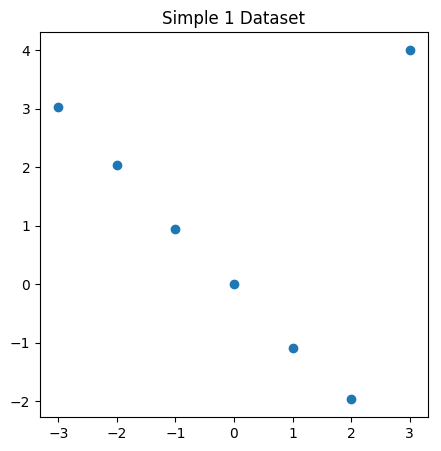

PyObject <matplotlib.text.Text object at 0x324ea17d0>

In [2]:
srand(1)
xs = collect(linspace(-3, 3, 7))
ys = -xs + randn(length(xs)) * 0.1
ys[end] = 4 # an outlier 

# Plotting dataset
plt[:figure](figsize=(5, 5))
plt[:scatter](xs, ys);
plt[:title]("Simple 1 Dataset")

Now, we show example outputs of a Metropolis-Hastings inference algorithm using RANSAC as our custom proposal **given this dataset**.

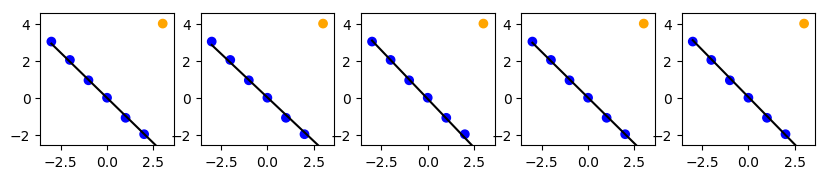

In [3]:
num_samples = 5.
proposal_noise = .2

demo(xs, ys, proposal_noise, num_samples)

### Noise in a Proposal
In order for a custom proposal to work with inference, we must add some noise. This is added to take into account `uncertainity` in the model. 

The noise added to the proposal is important. It makes the difference of how fast and well the program converges. 

**Let's try a different dataset.**

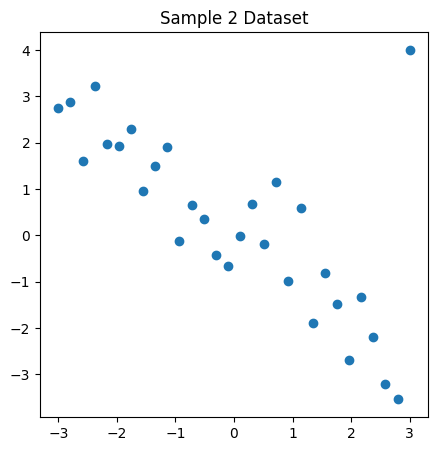

PyObject <matplotlib.text.Text object at 0x325614e10>

In [4]:
srand(40)
xs = collect(linspace(-3, 3, 30))
ys = -xs + randn(length(xs)) * 0.7
ys[end] = 4 # an outlier 

plt[:figure](figsize=(5, 5))
plt[:scatter](xs, ys);
plt[:title]("Sample 2 Dataset")

### Let's try a small proposal noise: .0002

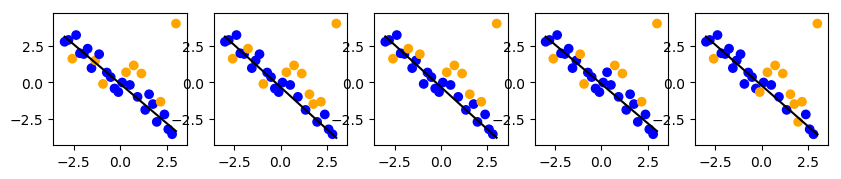

In [5]:
num_samples = 5.
proposal_noise = .0002

demo(xs, ys, proposal_noise, num_samples)

### Now, a large proposal noise: 10

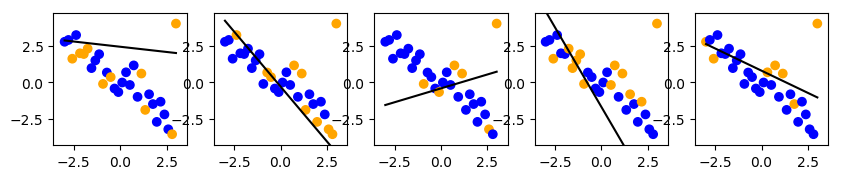

In [6]:
num_samples = 5.
proposal_noise = 10.

demo(xs, ys, proposal_noise, num_samples)

### Now, a proposal that's about right: 1.

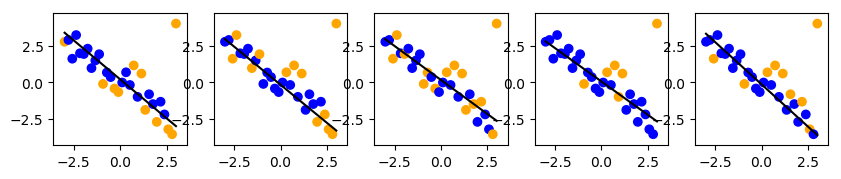

In [7]:
num_samples = 5.
proposal_noise = 1.

demo(xs, ys, proposal_noise, num_samples)

## RANSAC vs Inference with RANSAC proposal

Well, what's the difference between running the RANSAC algorithm on its own on the data compared to running inference and using it as a proposal? Well, there's one. ;)

Let's start off by running RANSAC and showing some sample outputs.

### Running Ransac 5 times with 1000 iterations

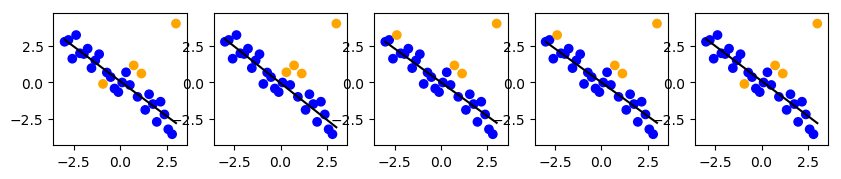

In [42]:
function mini_plot(xs::Array{Float64,1}, ys::Array{Float64,1}, slope::Float64, 
                        intercept::Float64, outliers::BitArray, i::Int)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    n = length(xs)
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    colors = map((i) -> outliers[i] ? "orange" : "blue", 1:n)
    plt[:scatter](xs, ys, c=colors)
    xs_line = [xmin, xmax]
    ys_line = intercept + slope * [xmin, xmax]
    plt[:plot](xs_line, ys_line, color="black")
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
    #ax[:fill_between](xs_line, 2, 0)
end

plt[:figure](figsize=(10, 10))
for i=1:5
    ransac_params = RansacParams(1000, 2, 1)
    slope, intercept, inliers = ransac_core(xs, ys, ransac_params)
    mini_plot(xs, ys, slope, intercept, !inliers, i)
    
end

### Let's See a Difference

Now, let's see if we can see a difference between sample outputs 
from the 4 different examples we've seen: 

* small proposal noise
* large proposal noise
* normal proposal noise
* RANSAC (alone)

In [28]:
function run_inference(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal_std::Float64, num_samples::Float64)
    traces = []
    for i=1:num_samples
        trace = linreg_infer_mh(100, xs, ys, proposal_std)
        push!(traces, trace)
    end
    traces
end

function run_ransac(xs::Array{Float64,1}, ys::Array{Float64,1}, num_samples::Float64)
    traces = []
    for i=1:num_samples
        ransac_params = RansacParams(1000, 2, 1)
        slope, intercept, inliers = ransac_core(xs, ys, ransac_params)
        push!(traces, [slope, intercept, inliers])
    end
    traces
end

run_ransac (generic function with 1 method)

In [55]:
function mini_plot_many(xs::Array{Float64,1}, ys::Array{Float64,1}, traces::Array{Any, 1}, i::Int)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    n = length(xs)
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    
    plt[:scatter](xs, ys, c="lightgrey")
    for (i, trace) in enumerate(traces)
        #colors = map((i) -> outliers[i] ? "orange" : "blue", 1:n)
        #plt[:scatter](xs, ys, c=colors)
        intercept = trace["intercept"]
        slope = trace["slope"]
        
        xs_line = [xmin, xmax]
        ys_line = intercept + slope * [xmin, xmax]
        plt[:plot](xs_line, ys_line, color="orange")
    end
    
    
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
    #ax[:fill_between](xs_line, 2, 0)
end

mini_plot_many (generic function with 1 method)

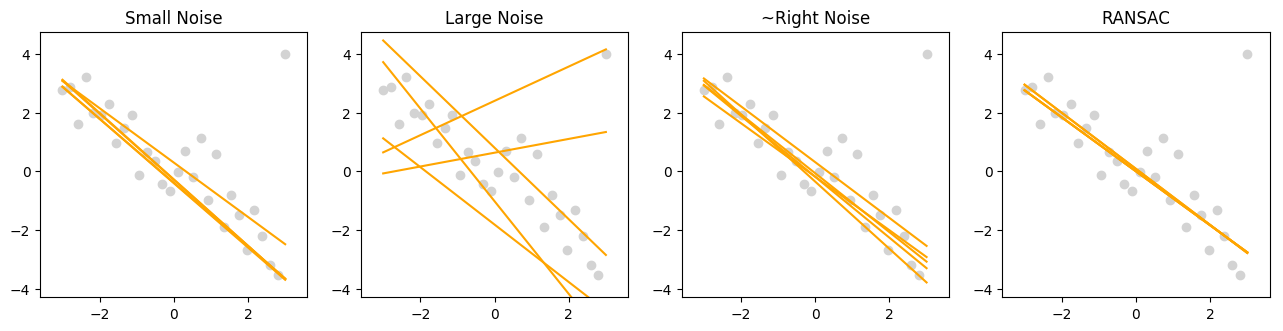

In [66]:
num_samples = 5.

#----- INFERENCE WITH DIFF NOISE--
proposal_noise = .0002
traces_sm = run_inference(xs, ys, proposal_noise, num_samples)
proposal_noise = 10.
traces_lg = run_inference(xs, ys, proposal_noise, num_samples)
proposal_noise = 1.
traces_reg = run_inference(xs, ys, proposal_noise, num_samples)

#----- RANSAC BY ITSELF ----------
ransac_data = run_ransac(xs, ys, num_samples)
traces_ransac = []

#just filling out the trace to plot 
for (i, data) in enumerate(ransac_data)
    trace = Trace()
    trace["slope"] = data[1]
    trace["intercept"] = data[2]
    push!(traces_ransac, trace)
end

#----------------------------------

# PLOT THE DIFFERENCES
titles = ["Small Noise", "Large Noise", "~Right Noise", "RANSAC"]
trace_list = [traces_sm, traces_lg, traces_reg, traces_ransac]
plt[:figure](figsize=(20, 20))
for i=1:4
    mini_plot_many(xs, ys, trace_list[i], i)
    plt[:title](titles[i])
end

In [67]:
# TODO TALK ABOUT THE BUG in the custom proposal and how inference makes up for it